In [219]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

#2020 population of Catalonia from https://www.idescat.cat/pub/?id=aec&n=245
popCatalunya = 7722203

#Catalonia's health department data https://dadescovid.cat/descarregues
resp = urlopen("https://dadescovid.cat/static/csv/catalunya_diari_total_pob.zip")
zipfile = ZipFile(BytesIO(resp.read()))
file = zipfile.namelist()[0]
df = pd.read_csv(zipfile.open(file), sep=";")
df.head()

,NOM,CODI,DATA,SEXE,GRUP_EDAT,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,...,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2
0,CATALUNYA,GLOBAL,2021-02-04,Altres,NaN,47,293,13,0,0,...,31,0,19,28,11,5,286,13,0,10
1,CATALUNYA,GLOBAL,2021-02-04,Dona,Entre 15 i 64,393,1541,4336,2,2,...,62,0,33,360,28,277,1352,4009,579,5711
2,CATALUNYA,GLOBAL,2021-02-04,Dona,Entre 65 i 74,45,120,403,0,2,...,57,0,6,39,8,31,109,397,29,177
3,CATALUNYA,GLOBAL,2021-02-04,Dona,Majors de 74,50,213,363,0,0,...,29,2,9,41,5,39,180,343,157,1398
4,CATALUNYA,GLOBAL,2021-02-04,Dona,Menors de 15,51,140,610,0,0,...,0,0,7,44,5,29,131,590,0,0


In [220]:
previousdf_columns = ['NOM',
 'CODI',
 'DATA',
 'SEXE',
 'GRUP_EDAT',
 'CASOS_CONFIRMAT',
 'PCR',
 'TAR',
 'INGRESSOS_TOTAL',
 'INGRESSOS_CRITIC',
 'INGRESSATS_TOTAL',
 'INGRESSATS_CRITIC',
 'EXITUS',
 'CASOS_PCR',
 'CASOS_TAR',
 'POSITIVITAT_PCR_NUM',
 'POSITIVITAT_TAR_NUM',
 'POSITIVITAT_PCR_DEN',
 'POSITIVITAT_TAR_DEN',
 'VACUNATS_DOSI_1',
 'VACUNATS_DOSI_2']
assert list(df.columns) == previousdf_columns, "Source data has changed format"

In [221]:
df["DATA"] = pd.to_datetime(df["DATA"])
dfagg = df.groupby("DATA").agg(sum)
dfagg.tail()

,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2
DATA,,,,,,,,,,,,,,,,
2021-01-31,824,6144,4218,134,37,3001,636,63,327,497,327,470,5572,3943,463,3869
2021-02-01,3179,33873,20393,187,56,2920,619,47,1510,1669,1500,1703,30567,18848,1402,9422
2021-02-02,2642,38293,17659,198,39,2817,616,61,1452,1190,1636,1310,34510,16341,885,11267
2021-02-03,1843,26850,16855,168,47,2743,591,33,773,1070,969,1114,23708,15669,623,11956
2021-02-04,1076,3762,9578,2,19,2642,584,3,135,941,112,740,3370,9045,1063,10054


In [222]:
dfaggvac = dfagg[dfagg["VACUNATS_DOSI_1"]>0]
dfaggvac.reset_index(inplace=True)
dfaggvac['Weekend'] = np.where(dfaggvac["DATA"].dt.weekday < 5,0,1)
dfaggvac["1st dose percent"] = dfaggvac["VACUNATS_DOSI_1"].cumsum()/popCatalunya*100
dfaggvac["2nd dose percent"] = dfaggvac["VACUNATS_DOSI_2"].cumsum()/popCatalunya*100
first_vaccination_date=min(dfaggvac["DATA"])
dfaggvac.head()

,DATA,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2,Weekend,1st dose percent,2nd dose percent
0,2020-12-27,1131,4998,4121,168,33,1757,321,42,404,727,331,573,4620,3896,803,0,1,0.010399,0.0
1,2020-12-28,4029,21864,19981,249,36,1803,335,47,1415,2614,1239,2377,19550,18550,1,0,0,0.010412,0.0
2,2020-12-29,3980,26516,19710,247,26,1820,335,44,1547,2433,1495,2301,23807,18180,447,0,0,0.016200,0.0
3,2020-12-30,3777,27734,19710,231,24,1805,328,47,1498,2279,1532,2232,24734,18473,2585,0,0,0.049675,0.0
4,2020-12-31,3409,22485,17208,229,37,1772,340,47,1448,1961,1630,2006,20148,16164,2591,0,0,0.083228,0.0


In [223]:
tidy = dfaggvac[["DATA","VACUNATS_DOSI_1","VACUNATS_DOSI_2"]]
tidy.columns = ["DATA","1st","2nd"]
tidy = tidy.melt(id_vars="DATA",ignore_index = False).rename(columns=str.title)
tidy.rename(columns = {'Variable': 'Dose'} , inplace=True)
tidy['Data'] = tidy['Data'].dt.strftime('%d-%b')


In [224]:
import matplotlib.ticker as ticker
from matplotlib import dates
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
sns.set_style('white')
dmax = max(dfaggvac["DATA"]) + pd.DateOffset(1)
dmin = min(dfaggvac["DATA"]) - pd.DateOffset(1)

<IPython.core.display.Javascript object>


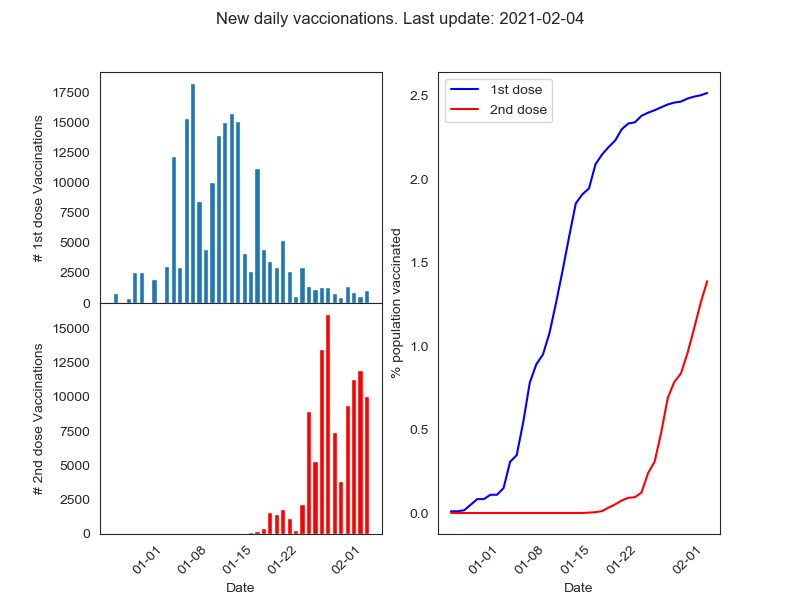

In [225]:
fig = plt.figure(figsize=(8, 6))

gs = fig.add_gridspec(2,2)

date_form = DateFormatter("%m-%d")
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
fig.suptitle("New daily vaccionations. Last update: " + max(dfaggvac["DATA"]).strftime("%Y-%m-%d"))

# Defining custom 'xlim' and 'ylim' values.
maxx = max(dfaggvac["VACUNATS_DOSI_1"].max(),dfaggvac["VACUNATS_DOSI_2"].max())
custom_ylim = (0, maxx+1000)

# Setting the values for all axes.
plt.setp(ax1, ylim=custom_ylim)

ax1 = fig.add_subplot(gs[0, 0])

ax1.bar(x="DATA", height="VACUNATS_DOSI_1",data=dfaggvac)
ax1.set_ylabel("# 1st dose Vaccinations")
ax1.xaxis.set_major_formatter(date_form)

ax2 = fig.add_subplot(gs[1, 0])


ax2.bar(x="DATA", height="VACUNATS_DOSI_2",data=dfaggvac, color="red")
ax2.set_xlabel("Date")
ax2.set_ylabel("# 2nd dose Vaccinations")
ax2.xaxis.set_major_formatter(date_form)
ax2.tick_params(axis="x",rotation=45)

ax3 = fig.add_subplot(gs[:, 1])

ax3.plot(dfaggvac["DATA"], dfaggvac["1st dose percent"], color="blue", label="1st dose")
ax3.plot(dfaggvac["DATA"], dfaggvac["2nd dose percent"], color="red", label="2nd dose")

ax3.set_xlabel("Date")
ax3.set_ylabel("% population vaccinated")
ax3.xaxis.set_major_formatter(date_form)
ax3.legend()
ax3.tick_params(axis="x",rotation=45)

plt.show()
plt.savefig('CurrentOverallVaccinationCat.png')

<IPython.core.display.Javascript object>


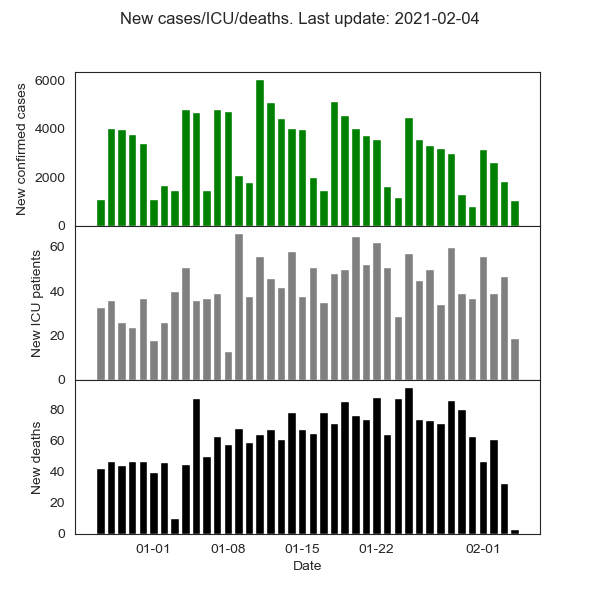

In [226]:
fig3, ax3 = plt.subplots(3,1,figsize=(6, 6), sharex=True)
date_form = DateFormatter("%m-%d")
# Remove horizontal space between axes
fig3.subplots_adjust(hspace=0)
fig3.suptitle("New cases/ICU/deaths. Last update: " + max(dfaggvac["DATA"]).strftime("%Y-%m-%d"))

ax3[0].bar(x="DATA", height="CASOS_CONFIRMAT",data=dfaggvac, color="green")
ax3[0].set_ylabel("New confirmed cases")

ax3[1].bar(x="DATA", height="INGRESSOS_CRITIC",data=dfaggvac, color="grey")
ax3[1].set_ylabel("New ICU patients")

ax3[2].bar(x="DATA", height="EXITUS",data=dfaggvac, color="black")
ax3[2].set_xlabel("Date")
ax3[2].set_ylabel("New deaths")
ax3[2].xaxis.set_major_formatter(date_form)

plt.show()
plt.savefig('CurrentCasesICUDeathsCat.png')

In [227]:
dfage = df.groupby(["DATA","GRUP_EDAT"]).agg(sum)
dfage.head()
#Població per sexe i grups d'edat: https://www.idescat.cat/pub/?id=aec&n=253


CASOS_CONFIRMAT  PCR  TAR  INGRESSOS_TOTAL  \
DATA       GRUP_EDAT                                                   
2020-03-01 Entre 15 i 64                1   12    0                0   
           Entre 65 i 74                0    4    0                0   
           Majors de 74                 0    4    0                0   
           Menors de 15                 0    0    0                0   
2020-03-02 Entre 15 i 64                4   26    0                0   

                          INGRESSOS_CRITIC  INGRESSATS_TOTAL  \
DATA       GRUP_EDAT                                           
2020-03-01 Entre 15 i 64                 0                 0   
           Entre 65 i 74                 0                 0   
           Majors de 74                  0                 0   
           Menors de 15                  0                 0   
2020-03-02 Entre 15 i 64                 0                 0   

                          INGRESSATS_CRITIC  EXITUS  CASOS_PCR  CASOS_TAR  \
DATA       GRUP_EDAT                                                        
2020-03-01 Entre 15 i 64                  0       0          1          0   
           Entre 65 i 74                  0       0          0          0   
           Majors de 74                   0       0          0          0   
           Menors de 15                   0       0          0          0   
2020-03-02 Entre 15 i 64                  0       0          4          0   

                          POSITIVITAT_PCR_NUM  POSITIVITAT_TAR_NUM  \
DATA       GRUP_EDAT                                                 
2020-03-01 Entre 15 i 64                    0                    0   
           Entre 65 i 74                    0                    0   
           Majors de 74                     0                    0   
           Menors de 15                     0                    0   
2020-03-02 Entre 15 i 64                    2                    0   

                          POSITIVITAT_PCR_DEN  POSITIVITAT_TAR_DEN  \
DATA       GRUP_EDAT                                                 
2020-03-01 Entre 15 i 64                   12                    0   
           Entre 65 i 74                    4                    0   
           Majors de 74                     4                    0   
           Menors de 15                     0                    0   
2020-03-02 Entre 15 i 64                   26                    0   

                          VACUNATS_DOSI_1  VACUNATS_DOSI_2  
DATA       GRUP_EDAT                                        
2020-03-01 Entre 15 i 64                0                0  
           Entre 65 i 74                0                0  
           Majors de 74                 0                0  
           Menors de 15                 0                0  
2020-03-02 Entre 15 i 64                0                0

In [228]:
#Downloaded from https://www.idescat.cat/pub/?id=aec&n=253
popdf = pd.read_html("aec-253.xls")
popdf = popdf[0]
popdf = popdf[:-4]
popdf = popdf[["Unnamed: 0", "Homes", "Dones", "Total"]]
popdf.rename(columns={"Unnamed: 0":"Age range", "Homes" : "Men", "Dones":"Women"},inplace=True)
popdf.replace({'\.':''}, regex=True,inplace=True)
popdf = popdf.astype({'Men': 'int64','Women': 'int64','Total': 'int64'})
popdf

,Age range,Men,Women,Total
0,De 0 a 4 anys,177639,168224,345863
1,De 5 a 9 anys,207060,194449,401509
2,De 10 a 14 anys,223267,208376,431643
3,De 15 a 19 anys,210527,193260,403787
4,De 20 a 24 anys,205008,191087,396095
5,De 25 a 29 anys,221110,216044,437154
6,De 30 a 34 anys,231001,235104,466105
7,De 35 a 39 anys,270896,274488,545384
8,De 40 a 44 anys,334557,325651,660208
9,De 45 a 49 anys,324031,313261,637292


In [229]:
df["GRUP_EDAT"].unique()

array([nan, 'Entre 15 i 64', 'Entre 65 i 74', 'Majors de 74',
       'Menors de 15'], dtype=object)

In [230]:
popranges = np.sum(popdf.loc[0:3,"Total"]), np.sum(popdf.loc[3:13,"Total"]), np.sum(popdf.loc[13:15,"Total"]),np.sum(popdf.loc[15:,"Total"])

In [231]:
popranges = pd.Series(popranges,index=['Menors de 15','Entre 15 i 64', 'Entre 65 i 74', 'Majors de 74'])
popranges

Menors de 15     1582802
Entre 15 i 64    5462530
Entre 65 i 74    1016572
Majors de 74      725118
dtype: int64

In [232]:
dfage.reset_index(inplace=True)
dfage

,DATA,GRUP_EDAT,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2
0,2020-03-01,Entre 15 i 64,1,12,0,0,0,0,0,0,1,0,0,0,12,0,0,0
1,2020-03-01,Entre 65 i 74,0,4,0,0,0,0,0,0,0,0,0,0,4,0,0,0
2,2020-03-01,Majors de 74,0,4,0,0,0,0,0,0,0,0,0,0,4,0,0,0
3,2020-03-01,Menors de 15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2020-03-02,Entre 15 i 64,4,26,0,0,0,0,0,0,4,0,2,0,26,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,2021-02-03,Menors de 15,302,3899,2211,0,0,3,0,0,185,117,210,124,3763,2165,0,0
1360,2021-02-04,Entre 15 i 64,715,2524,6839,2,9,873,240,0,62,653,61,524,2240,6402,807,7822
1361,2021-02-04,Entre 65 i 74,98,263,729,0,8,654,213,1,15,83,16,65,238,708,51,373
1362,2021-02-04,Majors de 74,94,382,650,0,2,1004,100,2,17,77,12,72,323,614,205,1849


In [233]:
dfage = dfage[dfage.DATA>=first_vaccination_date]
aggAgedf = []
for x in popranges.index:
    x1 = dfage[dfage.GRUP_EDAT==x]
    x1["1st dose percent"] =  x1["VACUNATS_DOSI_1"].cumsum()/popranges[x]*100
    x1["2nd dose percent"] =  x1["VACUNATS_DOSI_2"].cumsum()/popranges[x]*100
    
    aggAgedf.append(x1)

<IPython.core.display.Javascript object>


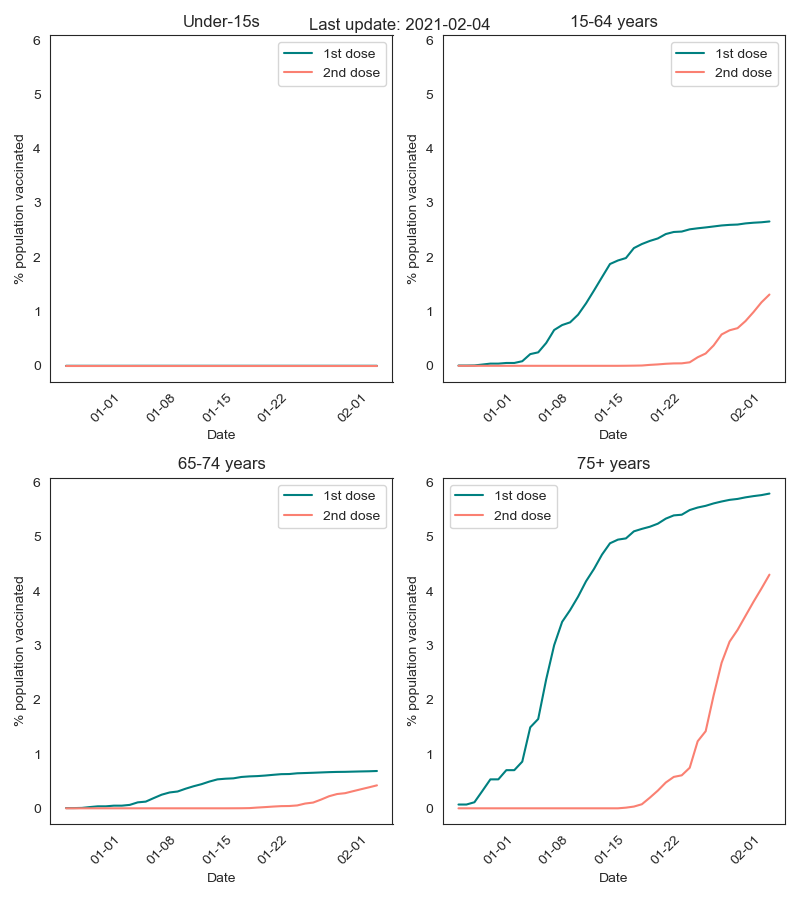

In [234]:
fig = plt.figure(figsize=(8, 9))
fig.suptitle("Last update: " + max(aggAgedf[0]["DATA"]).strftime("%Y-%m-%d"))

gs = fig.add_gridspec(2,2)


ax = fig.add_subplot(gs[0, 0])
ax.plot(aggAgedf[0]["DATA"], aggAgedf[0]["1st dose percent"], color="teal", label="1st dose")
ax.plot(aggAgedf[0]["DATA"], aggAgedf[0]["2nd dose percent"], color="salmon", label="2nd dose")
ax.set_xlabel("Date")
ax.set_ylabel("% population vaccinated")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.tick_params(axis="x",rotation=45)
ax.title.set_text("Under-15s")


ax = fig.add_subplot(gs[0, 1], sharey=ax)
ax.plot(aggAgedf[1]["DATA"], aggAgedf[1]["1st dose percent"], color="teal", label="1st dose")
ax.plot(aggAgedf[1]["DATA"], aggAgedf[1]["2nd dose percent"], color="salmon", label="2nd dose")
ax.set_xlabel("Date")
ax.set_ylabel("% population vaccinated")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.tick_params(axis="x",rotation=45)
ax.title.set_text("15-64 years")


ax = fig.add_subplot(gs[1, 0], sharey=ax)
ax.plot(aggAgedf[2]["DATA"], aggAgedf[2]["1st dose percent"], color="teal", label="1st dose")
ax.plot(aggAgedf[2]["DATA"], aggAgedf[2]["2nd dose percent"], color="salmon", label="2nd dose")
ax.set_xlabel("Date")
ax.set_ylabel("% population vaccinated")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.tick_params(axis="x",rotation=45)
ax.title.set_text("65-74 years")


ax = fig.add_subplot(gs[1, 1], sharey=ax)
ax.plot(aggAgedf[3]["DATA"], aggAgedf[3]["1st dose percent"], color="teal", label="1st dose")
ax.plot(aggAgedf[3]["DATA"], aggAgedf[3]["2nd dose percent"], color="salmon", label="2nd dose")
ax.set_xlabel("Date")
ax.set_ylabel("% population vaccinated")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.tick_params(axis="x",rotation=45)
ax.title.set_text("75+ years")
gs.tight_layout(fig)

plt.show()
plt.savefig('CurrentByAgeVaccinationCat.png')